# Astronomy Department Friday Pizzas

Below we explore the financials and ordering strategies for the Friday pizza orders. These data were collected weekly since ~2011, though many records were incomplete and were discarded. To be considered complete and included in the following analysis, the pizza entry must include: 

* Number of pizzas ordered

* Number of pizzas left after end of sale

* Money spent on the pizza

* Money collected

[The source data](https://github.com/bmorris3/astropizzafridayfuntimes/blob/master/pizzadata.csv) are available in a CSV file in our [repository on GitHub](https://github.com/bmorris3/astropizzafridayfuntimes).

In [6]:
%pylab inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14
import datetime
months = range(1,13)

pizzadatafile = open('pizzadata.csv','r').read().splitlines()
dates = []
pizzasordered = []
pizzasleft = []
moneyin = []
moneyout = []
# Read in the pizza data file
for i in range(1,len(pizzadatafile)):
    # Parse the dates, written in MM/DD/YY format, make datetime objects
    splitline = pizzadatafile[i].split(',')
    mm, dd, yearminus2000 = map(int,splitline[0].split('/'))
    year = int(2000 + yearminus2000)
    dates.append(datetime.datetime(year, mm, dd))
    
    pizzasordered.append(float(splitline[1]))
    pizzasleft.append(float(splitline[2]))
    moneyout.append(float(splitline[3]))
    moneyin.append(float(splitline[4]))

## Put in chronological order
dateorder = np.argsort(dates)
dates = np.array(dates)[dateorder]
pizzasordered = np.array(pizzasordered)[dateorder]
pizzasleft = np.array(pizzasleft)[dateorder]
moneyout = np.array(moneyout)[dateorder]
moneyin = np.array(moneyin)[dateorder]
dates_yr = np.array([int(i.strftime('%j'))/365.0 + i.year for i in dates])

## Get the month of each recorded order
months = np.array([date.month for date in dates])
ind = range(len(dates))

# Get the monthly medians of the pizzas ordered and pizzas left
median_ordered = np.zeros(12, dtype=float)
median_left = np.zeros(12, dtype=float)
median_ideal = np.zeros(12, dtype=float)
Norderspermonth = np.zeros(12, dtype=float)
for i in range(12):
    month = i + 1
    Norderspermonth[i] = sum(months == month)
    if Norderspermonth[i] > 0:
        median_ordered[i] = np.median(pizzasordered[months == month])
        median_left[i] = np.median(pizzasleft[months == month])
        median_ideal[i] = np.median(pizzasordered[months == month] - pizzasleft[months == month])

Populating the interactive namespace from numpy and matplotlib


## How many pizzas should be ordered per month?

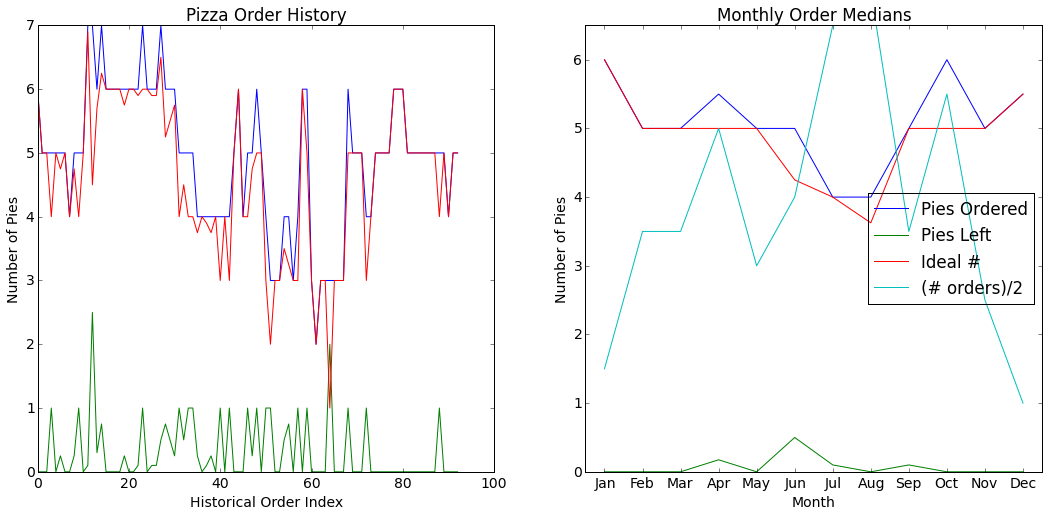

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(ind, pizzasordered, label='Pies Ordered')
ax[0].plot(ind, pizzasleft, label='Pies Left')
ax[0].plot(ind, pizzasordered-pizzasleft, label='Ideal #')

ax[0].set_title('Pizza Order History')
ax[0].set_xlabel('Historical Order Index')
ax[0].set_ylabel('Number of Pies')

monthrange = range(12)
ax[1].plot(monthrange, median_ordered, label='Pies Ordered')
ax[1].plot(monthrange, median_left, label='Pies Left')
ax[1].plot(monthrange, median_ideal, label='Ideal #')
ax[1].plot(monthrange, Norderspermonth/2, label='(# orders)/2')

ax[1].set_title('Monthly Order Medians')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Number of Pies')
ax[1].set_xticks(monthrange)
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', \
                    'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[1].set_xlim([-0.5, 11.5])
ax[1].legend(numpoints=1, loc='center right')
ax[1].set_ylim([0, 6.5])

plt.show()

### Assuming a sinusoidal pizza consumption model:

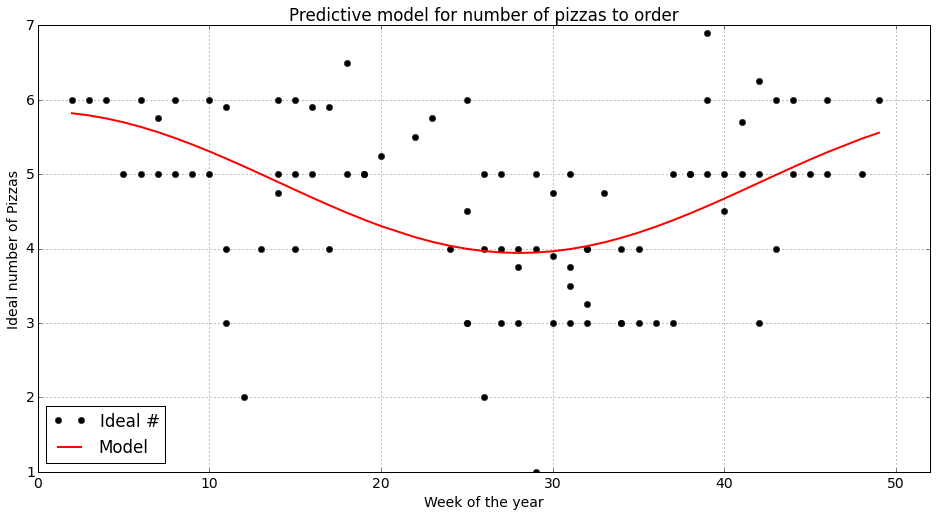

In [8]:
from scipy import optimize

dates_week = np.array([int(i.strftime('%U')) for i in dates])
idealnumber = pizzasordered - pizzasleft

def fitfunc(p, x=dates_week):
    return p[0]*np.cos(2*pi*x/p[1]) + p[2]
def errfunc(p):
    return fitfunc(p) - idealnumber
    
bestp, success = optimize.leastsq(errfunc, [1.5, 52, 4])

fig, ax = plt.subplots(1,figsize=(16,8))
ax.plot(dates_week, idealnumber, 'ko', label='Ideal #')
ax.plot(sorted(dates_week), fitfunc(bestp)[np.argsort(dates_week)], lw=2, color='r', label='Model')
ax.set_ylabel('Ideal number of Pizzas')
ax.set_xlabel('Week of the year')
ax.set_title('Predictive model for number of pizzas to order')
ax.grid()
ax.legend(loc='lower left')
ax.set_xlim([0,52])
plt.show()

Using [weather data from Seattle Boeing Airfield](http://www.climate.washington.edu/cloudcover/BoeingFld_1971-2000_monthlyData.txt): 

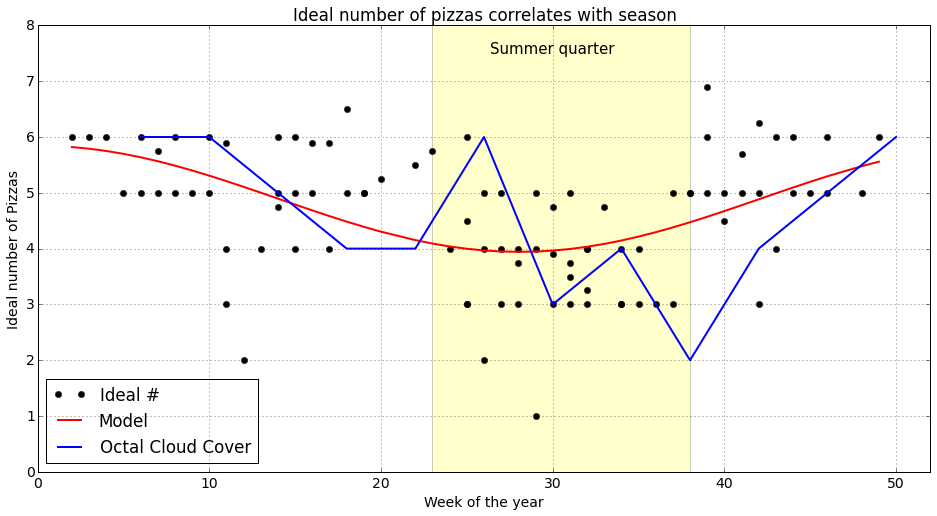

In [9]:
weatherdata = open('weatherdata.csv', 'r').readlines()
weather_months = np.arange(1,13)
cloudcover = np.zeros_like(weather_months)
for i, line in enumerate(weatherdata):
    if not 'NaN' in line and len(line)>1:
        cc_yr, cc_month, cc, _, _, _ = map(float,line.split(','))
        cloudcover[int(cc_month) - 1] = cc
        
fig, ax = plt.subplots(1,figsize=(16,8))
ax.plot(dates_week, idealnumber, 'ko', label='Ideal #')
ax.plot(sorted(dates_week), fitfunc(bestp)[np.argsort(dates_week)], lw=2, color='r', label='Model')
ax.plot(weather_months*4 + 2, cloudcover, lw=2, color='b', label='Octal Cloud Cover')

# Highlight summer quarter
ax.fill_between([int(datetime.datetime(2014,6,12).strftime('%U')), \
                 int(datetime.datetime(2014,9,25).strftime('%U'))],\
                 0, 8, facecolor='yellow', alpha=0.2,
                 label='Summer')
ax.annotate('Summer quarter', (30, 7.5), textcoords='data', ha='center', fontsize=15)

ax.set_ylabel('Ideal number of Pizzas')
ax.set_xlabel('Week of the year')
ax.set_title('Ideal number of pizzas correlates with season')
ax.grid()
ax.set_xlim([0,52])
ax.legend(loc='lower left')
plt.show()

## How much money was made or lost overall?

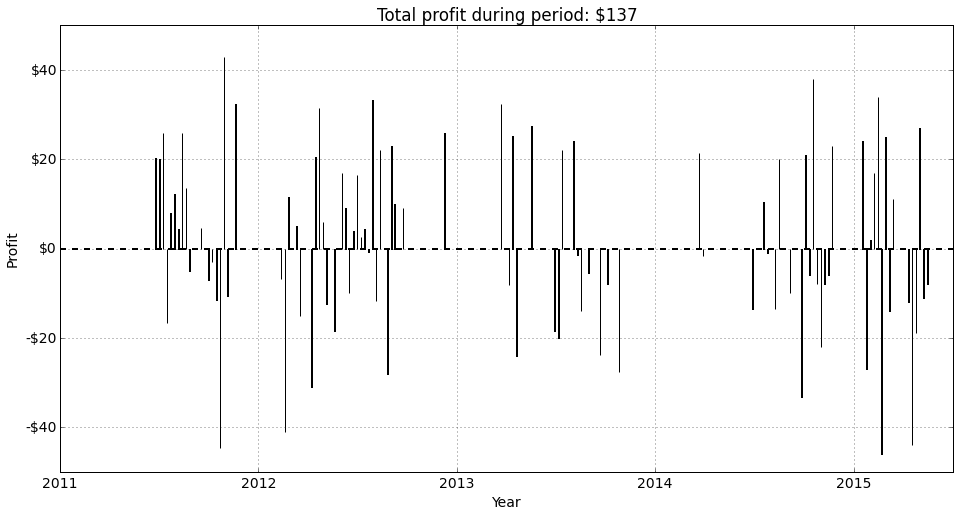

In [10]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(1, figsize=(16,8))
ax.bar(dates_yr, moneyin-moneyout, width=1./365, color='k')
xaxisrange = range(2011,2016)
ax.set_xticks(xaxisrange)
ax.set_xticklabels(map(str,xaxisrange))

def moneyformat(dollars, pos):
    if dollars < 0:
        return '-$%d' % np.abs(dollars)
    else: 
        return '$%d' % dollars

formatter = FuncFormatter(moneyformat)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Total profit during period: $%d' % np.sum(moneyin-moneyout))
ax.set_ylabel('Profit')
ax.set_xlabel('Year')
ax.grid()
ax.axhline(0, lw=2, ls='--', color='k')
plt.show()